In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
import tf_slim as slim

In [ ]:
def SRM(imgs):
    c=np.zeros((3,5,5))
    c[0]=[[-1,2,-2,2,-1],[2,-6,8,-6,2],[-2,8,-12,8,-2],[2,-6,8,-6,2],[-1,2,-2,2,-1]]
    c[0]=c[0]/12

    c[1][1][1]=-1
    c[1][1][2]=2
    c[1][1][3]=-1
    c[1][2][1]=2
    c[1][2][2]=-4
    c[1][2][3]=2
    c[1][3][1]=-1
    c[1][3][2]=2
    c[1][3][3]=-1
    c[1]=c[1]/4

    c[2][1][2]=1
    c[2][2][2]=-2
    c[2][3][2]=1
    c[2]=c[2]/2   

    Wcnn=np.zeros((5,5,3,3))
    for i in range(3):
        Wcnn[:,:,0,i]=c[i]
        Wcnn[:,:,1,i]=c[i]
        Wcnn[:,:,2,i]=c[i]

    imgs = np.array(imgs, dtype=float)
    input = tf.Variable(imgs, dtype=tf.float32)

    conv = tf.nn.conv2d(input, Wcnn, [1, 1, 1, 1], padding='SAME',name='srm')
    res = np.array(conv, dtype=float)
    return res

In [ ]:
h = 224
w = 224
image_size = (h, w)

def prepare_image(image_path):
    img = Image.open(image_path)
    img = img.resize(image_size)
    img = np.asarray(img) / 255.0
    return SRM([img])

In [ ]:
def prepare_data(path, cls):
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            if filename.endswith('jpg') or filename.endswith('png'):
                try:
                    full_path = os.path.join(dirname, filename)
                    X.append(prepare_image(full_path))
                    Y.append(cls)
                except:
                    print('Image unable to open. Moving on!')
                if len(Y) % 500 == 0:
                    print('Processing {} images'.format(len(Y)))

In [ ]:
Au_path = '../CASIA/CASIA2/Au/'
prepare_data(Au_path, 1)
random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

In [11]:
def PlotImage(image):
    """
	PlotImage: Give a normalized image matrix which can be used with implot, etc.
	Maps to [0, 1]
	"""
    im = image.astype(float)
    return (im - np.min(im)) / (np.max(im) - np.min(im))


In [18]:
def SRM(imgs):
    filter1 = [[0, 0, 0, 0, 0],
               [0, -1, 2, -1, 0],
               [0, 2, -4, 2, 0],
               [0, -1, 2, -1, 0],
               [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
               [2, -6, 8, -6, 2],
               [-2, 8, -12, 8, -2],
               [2, -6, 8, -6, 2],
               [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 1, -2, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0]]
    q = [4.0, 12.0, 2.0]
    filter1 = np.asarray(filter1, dtype=float) / 4
    filter2 = np.asarray(filter2, dtype=float) / 12
    filter3 = np.asarray(filter3, dtype=float) / 2
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = tf.Variable(filters, dtype=tf.float32)
    imgs = np.array(imgs, dtype=float)
    input = tf.Variable(imgs, dtype=tf.float32)
    op = tf.nn.conv2d(input, filters, strides=[1, 1, 1, 1], padding='SAME')

    q = [4.0, 12.0, 2.0]
    filter1 = [[0, 0, 0, 0, 0],
            [0, -1, 2, -1, 0],
            [0, 2, -4, 2, 0],
            [0, -1, 2, -1, 0],
            [0, 0, 0, 0, 0]]
    filter2 = [[-1, 2, -2, 2, -1],
            [2, -6, 8, -6, 2],
            [-2, 8, -12, 8, -2],
            [2, -6, 8, -6, 2],
            [-1, 2, -2, 2, -1]]
    filter3 = [[0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 1, -2, 1, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0]]
    filter1 = np.asarray(filter1, dtype=float) / q[0]
    filter2 = np.asarray(filter2, dtype=float) / q[1]
    filter3 = np.asarray(filter3, dtype=float) / q[2]
    filters = [[filter1, filter1, filter1], [filter2, filter2, filter2], [filter3, filter3, filter3]]
    filters = np.einsum('klij->ijlk', filters)
    filters = filters.flatten()
    imgs = np.array(imgs, dtype=float)
    input = tf.Variable(imgs, dtype=tf.float32)
    initializer_srm = tf.constant_initializer(filters)
    def truncate_2(x):
        neg = ((x + 2) + abs(x + 2)) / 2 - 2
        return -(-neg+2 + abs(- neg+2)) / 2 + 2
    op2 = slim.conv2d(input, 3, [5, 5], trainable=False, weights_initializer=initializer_srm, activation_fn=None, padding='SAME', stride=1, scope='srm')
    op2 = truncate_2(op2)

    res = np.round(op[0])
    res[res > 2] = 2
    res[res < -2] = -2

    ress = np.array([res], dtype=float)
    ress2 = np.array(op2, dtype=float)
    return ress2, ress

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


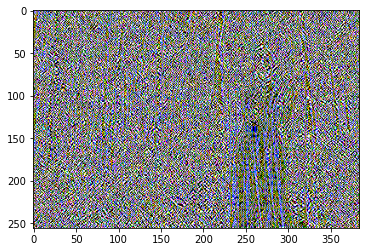

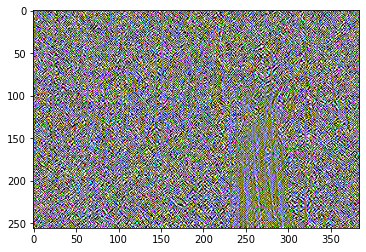

In [62]:
img = Image.open('Tp_D_NNN_M_N_pla10121_cha00027_11669.jpg')
# img = img.resize((224, 224))
img = np.asarray(img)
img, img2 = SRM([img])
plt.imshow(img[0])
plt.show()

plt.imshow(PlotImage(img2[0]))
plt.show()

In [40]:
img

array([[[[-8.23531151e-02, -7.94117451e-02, -1.64705753e-01],
         [ 5.88226318e-03,  2.45099068e-02,  1.76470280e-02],
         [ 2.05881596e-02,  1.76470280e-02,  2.94117928e-02],
         ...,
         [ 0.00000000e+00,  2.94113159e-03,  0.00000000e+00],
         [ 0.00000000e+00,  7.25491047e-02,  0.00000000e+00],
         [-2.19607830e-01, -2.18954086e-01, -4.39215660e-01]],

        [[-2.94113159e-03,  2.54902840e-02, -1.64705753e-01],
         [ 5.88226318e-03, -1.76470280e-02,  2.35292912e-02],
         [-2.94113159e-03, -6.86264038e-03,  1.76470280e-02],
         ...,
         [ 0.00000000e+00, -9.80377197e-04,  0.00000000e+00],
         [ 0.00000000e+00, -7.25488663e-02,  0.00000000e+00],
         [-1.96075439e-03,  7.12418556e-02, -4.39215660e-01]],

        [[-5.88226318e-03, -1.96075439e-03, -1.58823490e-01],
         [ 2.94113159e-03, -9.80377197e-04,  1.76470280e-02],
         [ 2.94113159e-03,  7.84325600e-03,  1.17647648e-02],
         ...,
         [ 0.00000000e+0